# Iterative Backtesting

This implementation helps testing and optimizing SMA strategy with historical binance data.

In [1]:
api_key = "6ce63f3406fd8ebbff01054a66c25fe3c851c45932088c8ca3131a7005188462"
secret_key = "aa3ea32929252467fa5ffeac5818c95beabfb5dba691ef445e7eaa31ea0d15f6"

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [143]:
#OLD VERSION
class IterativeBase():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()

    def get_data(self):
        raw = pd.read_csv("5m.csv", parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw = raw[["Close"]].rename(columns={"Close": "price"}) #just use these columns
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None):  
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
    
    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        return date, price
    
    def print_current_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        lev = self.leverage
        fee = 0
        if units is None: # use units if units are passed, otherwise calculate units
            units = amount / price
        if self.use_fee: #remove fee units, then you buy less units than desired   
            fee = units * self.fee_taker
            units = units - fee
            
        self.current_balance -= ( units/lev + fee ) * price # reduce cash balance by "purchase price"
        self.units += units
        self.trades += 1
        print("{} |  Buying {} for {}".format(date, units, round(price, 5)))
    
    def sell_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        lev = self.leverage
        fee = 0
        if units is None: # use units if units are passed, otherwise calculate units
            units = amount / price
        if self.use_fee: #remove fee units, then you sell all desired units buy paying a fee
            fee = units * self.fee_taker
            units = units - fee
            
        self.current_balance += ( units ) * price # increase cash balance by "purchase price"
        self.units -= units/lev + fee 
        self.trades += 1
        print("{} |  Selling {} for {}".format(date, units, round(price, 5)))
    
    def print_current_position_value(self, bar):
        date, price = self.get_values(bar)
        cpv = self.units * price
        print("{} |  Current Position Value = {}".format(date, round(cpv, 2)))
    
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def close_pos(self, bar):
        date, price = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        cpv = self.units * price
        self.current_balance += cpv # closing final position (works with short and long!)
        self.current_balance -= cpv * self.fee_taker * self.use_fee # substract fee costs
        print("{} | closing position of {} for {}".format(date, self.units, price))
        self.units = 0 # setting position to neutral
        self.trades += 1
        self.position = 0
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, self.trades))
        print(75 * "-")
    def get_nav(self, bar):
        date, price = self.get_values(bar)
        return self.current_balance + self.units * price

In [301]:
#WORKING ON THIS!!
class IterativeBase():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.current_balance = amount
        self.unlev_units = 0 #keeps unlevered units
        self.units = 0 #keeps position units (unlev_units*leverage)
        self.trades = 0
        self.position = 0
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()

    def get_data(self):
        raw = pd.read_csv("5m.csv", parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw = raw[["Close"]].rename(columns={"Close": "price"}) #just use these columns
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None):  
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
    
    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        return date, price
    
    def print_current_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        lev = self.leverage
        fee = 0
        if units is None: # use units if units are passed, otherwise calculate units
            units = amount / price
        if self.use_fee: #remove fee units, then you buy less units than desired   
            fee = units * self.fee_taker
            units = units - fee    
        if self.position in [0]: #open long position
            self.entry_price = price
            unlev_units = units/lev
            self.current_balance -= ( unlev_units + fee ) * price # reduce cash balance by "purchase price"
            self.unlev_units += unlev_units
            self.units = units
            self.trades += 1
            self.position = 1
            print("{} |  Buying {} for {}, leverage {}".format(date, units, round(price, 5), self.leverage))
        elif self.position in [-1]: #closing short position
            self.close_position(price, units, fee)
            print("{} |  Buying (closing) {} for {}".format(date, units, round(price, 5)))
            
    def sell_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        lev = self.leverage
        fee = 0
        if units is None: # use units if units are passed, otherwise calculate units
            units = amount / price
        if self.use_fee: #remove fee units, then you sell all desired units buy paying a fee
            fee = units * self.fee_taker
            units = units - fee
        if self.position in [0]: #open short position
            self.entry_price = price
            unlev_units = units/lev
            self.current_balance += ( unlev_units ) * price # increase cash balance by "purchase price"
            self.unlev_units -= unlev_units + fee 
            self.units -= units + fee
            self.trades += 1
            self.position = -1
            print("{} |  Selling {} for {}, leverage {}".format(date, units, round(price, 5), self.leverage))
        elif self.position in [1]: #closing long position
            self.close_position(price, units, fee)
            print("{} |  Selling (closing) {} for {}".format(date, units, round(price, 5)))
            
    def print_current_position_value(self, bar):
        date, price = self.get_values(bar)
        cpv = self.unlev_units * price
        print("{} |  Current Position Value = {}".format(date, round(cpv, 2)))
    
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def get_nav(self, bar):
        date, price = self.get_values(bar)
        fee = abs(self.units) * price * self.fee_taker * self.use_fee 
        position_value = self.unlev_units * price
        return self.current_balance + position_value - fee
    
    def close_position(self, price, units, fee): #helper method for buy and sell instrument methods
        my_asset_entry_value = self.unlev_units * self.entry_price #self.unlev_units < 0 => my_asset_entre_value < 0
        profit = self.position*(units)* (price - self.entry_price) #units > 0 
        pay_fee = fee*price #pay_fee > 0
        self.current_balance += my_asset_entry_value +profit - pay_fee
        self.unlev_units = 0
        self.units = 0
        self.trades += 1
        self.position = 0

In [349]:
class IterativeBacktest(IterativeBase):

    # helper method
    def go_long(self, bar, units = None, amount = None):
        if self.position == -1:
            self.buy_instrument(bar, units = -self.units) # if short position, go neutral first
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance * self.leverage
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None):
        if self.position == 1:
            self.sell_instrument(bar, units = self.units) # if long position, go neutral first
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance * self.leverage
            self.sell_instrument(bar, amount = amount) # go short

    def test_sma_strategy(self, SMA_S, SMA_L, keep_metrics = True):
        
        # nice printout
        stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}".format(self.symbol, SMA_S, SMA_L)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        
        # prepare data
        self.data["SMA_S"] = self.data["price"].rolling(SMA_S).mean()
        self.data["SMA_L"] = self.data["price"].rolling(SMA_L).mean()
        self.data.dropna(inplace = True)
        
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
        self.leverage = 1
        # sma crossover strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.data["SMA_S"].iloc[bar] > self.data["SMA_L"].iloc[bar]: # signal to go long
                if self.position in [0, -1]:
                    self.go_long(bar, amount = "all") # go long with full amount
            elif self.data["SMA_S"].iloc[bar] < self.data["SMA_L"].iloc[bar]: # signal to go short
                if self.position in [0, 1]:
                    self.go_short(bar, amount = "all") # go short with full amount
            self.calculate_metrics(bar)        
                    
        self.close_final_position(bar+1) # close position at the last bar
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.position )
        self.navs.append( self.get_nav(bar) )
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions
        self.data["NAV"] = self.navs
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        if self.position in [-1]:
            self.buy_instrument(bar, units = -self.units)
        elif self.position in [1]:    
            self.sell_instrument(bar, units = self.units)
        self.unlev_units = 0 # setting position to neutral
        self.units = 0
        self.trades += 1
        self.position = 0
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, self.trades))
        print(75 * "-")    

In [350]:
bc = IterativeBacktest(symbol = "BTCUSD", 
                       start = "2022-01-31", 
                       end = "2023-06-30", 
                       amount = 100000, 
                       use_fee= True,
                       fee_maker = 0.0002,
                       fee_taker = 0.0004
                    )

In [116]:
bc.data

,price,returns,Hold Strategy
Date,,,
2022-07-12 11:15:00,19729.8,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,99918.904398
2022-07-12 11:25:00,19772.7,0.002983,100217.437582
2022-07-12 11:30:00,19823.3,0.002556,100473.902422
2022-07-12 11:35:00,19766.9,-0.002849,100188.040426
...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,124431.063670
2022-08-16 04:15:00,24450.0,-0.004082,123924.216160
2022-08-16 04:20:00,24508.3,0.002382,124219.708259


In [351]:
bc.test_sma_strategy(50, 200, True)

---------------------------------------------------------------------------
Testing SMA strategy | BTCUSD | SMA_S = 50 & SMA_L = 200
---------------------------------------------------------------------------
2022-07-13 |  Selling 5.130732037818361 for 19482.6, leverage 1
2022-07-13 |  Buying (closing) 5.130732037818361 for 19830.9
2022-07-13 |  Buying 4.946472325069857 for 19830.9, leverage 1
2022-07-13 |  Selling (closing) 4.94449373613983 for 19605.6
2022-07-13 |  Selling 4.942538666732016 for 19605.6, leverage 1
2022-07-13 |  Buying (closing) 4.942538666732016 for 19740.0
2022-07-13 |  Buying 4.8713089026750165 for 19740.0, leverage 1
2022-07-14 |  Selling (closing) 4.869360379113947 for 19748.5
2022-07-14 |  Selling 4.867411796628996 for 19748.5, leverage 1
2022-07-14 |  Buying (closing) 4.867411796628996 for 20199.8
2022-07-14 |  Buying 4.646111330627851 for 20199.8, leverage 1
2022-07-16 |  Selling (closing) 4.644252886095599 for 20690.8
2022-07-16 |  Selling 4.642351101035906 f

2022-08-02 |  Buying (closing) 2.6988452837019388 for 23513.1
2022-08-02 |  Buying 2.6395254377571535 for 23513.1, leverage 1
2022-08-02 |  Selling (closing) 2.6384696275820505 for 23268.9
2022-08-02 |  Selling 2.6374253157042364 for 23268.9, leverage 1
2022-08-03 |  Buying (closing) 2.6374253157042364 for 23588.7
2022-08-03 |  Buying 2.5638310429945363 for 23588.7, leverage 1
2022-08-04 |  Selling (closing) 2.5628055105773386 for 23844.0
2022-08-04 |  Selling 2.5617694122911274 for 23844.0, leverage 1
2022-08-05 |  Buying (closing) 2.5617694122911274 for 23148.3
2022-08-05 |  Buying 2.713641458893622 for 23148.3, leverage 1
2022-08-05 |  Selling (closing) 2.7125560023100648 for 23018.0
2022-08-05 |  Selling 2.7114771219900704 for 23018.0, leverage 1
2022-08-06 |  Buying (closing) 2.7114771219900704 for 23605.3
2022-08-06 |  Buying 2.57443877671148 for 23605.3, leverage 1
2022-08-06 |  Selling (closing) 2.5734090012007953 for 23208.4
2022-08-06 |  Selling 2.5723972413305605 for 23208.4

In [40]:
bc.buy_instrument(bar = 0, units = 0.1)

2022-08-04 |  Buying 0.09996000000000001 for 23198.0


In [56]:
bc.current_balance

52351.00666119373

In [45]:
bc.sell_instrument(bar = 0, units = 0.1)

2022-08-04 |  Selling 0.09996000000000001 for 23198.0


In [118]:
bc.units

2.142002267622539

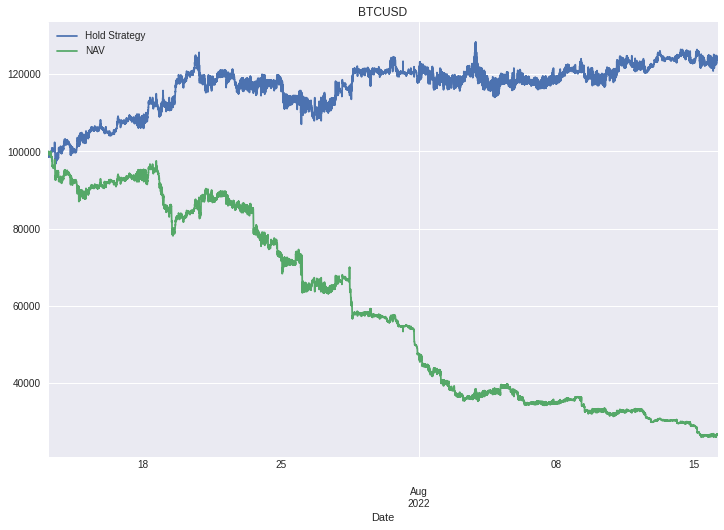

In [348]:
bc.plot_data(["Hold Strategy", "NAV"])

Add leverage and optimizer in function. 

In [311]:
bc.leverage = 5

In [312]:
bc.current_balance

100000

In [313]:
bc.units

0

In [314]:
bc.get_nav(0)

100000.0

In [315]:
bc.buy_instrument(0, amount = 100000)

2022-07-12 |  Buying 5.068475098581841 for 19729.8, leverage 5


In [317]:
bc.current_balance

80000.0

In [318]:
bc.unlev_units

1.013695019716368

In [319]:
bc.units*bc.data.price[0]

100000.0

In [320]:
bc.get_nav(0)

100000.0

In [321]:
bc.sell_instrument(0, amount = 100000)

2022-07-12 |  Selling (closing) 5.068475098581841 for 19729.8


In [322]:
bc.current_balance

100000.0

In [323]:
bc.units*bc.data.price[0]

0.0

In [324]:
bc.get_nav(0)

100000.0